#### Current State of Progress

All numbers are well-conditioned, thanks to: 
1. L1-clip all policy gradient partials to -1, 1. 
2. L1-clip the progress and up rewards.

However, the gradients are uninformative, and there's no convergence.

Next Steps:
- Load the standing policy & try again
- Don't consider policy gradients for any env that's had a large jacobian. Why? By chain rule, any large partial affects all parameters.
- Achieve longer unrolls: 
    - What % steps (ex. in contact) have bad jacobians?
    - Can we reduce this with simulation parameters?

Doesn't Work: 
- Observation history: policy gradient all nan.
- Filtering the action: doesn't do anything.

In [ ]:
import sys
from pathlib import Path
import functools

import mujoco
from brax import envs
import jax
import jax.numpy as jp

from envs import register_ahac_anymal
from shac.brax_wrappers import AppendObsHistory

import shac.networks as shac_networks
# import shac.train as  shac
from shac.train_class import SHAC

In [2]:
env_name = 'ahac_anymal'

log_sigma = None
make_networks_factory = functools.partial(
    shac_networks.make_shac_networks,
        policy_hidden_layer_sizes=(256, 128),
        value_hidden_layer_sizes =(256, 128),
        scalar_var=False,
        layer_norm=True)

In [3]:
# Debugging params
num_grad_checks = None
save_all_policy_gradients = True

# Training Parameters
unroll_length = 8 # Somewhat learns at 1. Doesn't at 8. Blows up at 16.

num_epochs = int(500 * (32 / unroll_length))
num_evals = num_epochs + 1
num_envs = 64

num_timesteps = (num_envs*unroll_length)*num_epochs

num_critic_minibatches = 4
num_critic_data = num_envs*unroll_length
critic_batch_size = num_critic_data / num_critic_minibatches

episode_length = 1000

polgrad_thresh = 1e6

# Environment Parameters
env_kwargs = {
    "s_afilt_buf" : 1, # Doesn't do anything. 
    "train_standing" : False,
    "termination_height" : 0.15,
    "phys_step" : 10,
    "model_variant" : "anymal"
}

h = 5 # The number of history steps.

In [4]:
# Warning: takes 40s
# env      = AppendObsHistory(envs.get_environment(env_name, **env_kwargs), h=h)
# eval_env = AppendObsHistory(envs.get_environment(env_name, **env_kwargs), h=h)
env = envs.get_environment(env_name, **env_kwargs)
eval_env = envs.get_environment(env_name, **env_kwargs)

/home/andrew/Documents/thesis/jax_shac/envs/register_ahac_anymal.py:132: UserWarning: s_afilt_buf > 1 gives undefined observations
  warnings.warn("s_afilt_buf > 1 gives undefined observations")


In [5]:
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)


In [6]:
# state = jit_reset(jax.random.PRNGKey(0))
# state.obs
# state = jit_step(state, -1*jp.ones(1))
# state.obs
# state = jit_step(state, -1*jp.ones(1))
# state.obs

# state.obs.shape

In [7]:
# state.info['reward_tuple']

In [8]:
kwargs = dict( 
  num_timesteps=num_timesteps, log_sigma=log_sigma,
  num_evals=num_evals, use_tbx=True, tbx_logdir=f'{env_name}_log',
  tbx_experiment_name="obs_hist_unroll8", reward_scaling=1, 
  num_eval_envs = 64, num_envs=num_envs,
  unroll_length=unroll_length, critic_batch_size=critic_batch_size,
  critic_epochs = 16,target_critic_alpha = 0.995,
  discounting = 0.99, lambda_ = 0.95,
  normalize_observations=True,
  episode_length=episode_length, 
  network_factory = make_networks_factory, 
  seed=0, entropy_cost = 1e-6,
  resample_init=True,
  scramble_initial_times=True,
  num_grad_checks=num_grad_checks,
  save_all_checkpoints=True,
  polgrad_thresh=polgrad_thresh,
  save_all_policy_gradients=save_all_policy_gradients
  )

trainer = SHAC(environment=env, eval_env=eval_env, **kwargs)

Env steps per training step: 512
Training steps per epoch: 1
Critic minibatches per critic epoch: 4


In [9]:
make_inference_fn, policy_params, value_params, _= trainer.train()

Initial eval time: 18.8846 s
Deleting old checkpoints!
Checkpointed for epoch 0
Checkpointed for epoch 1
Checkpointed for epoch 2
Checkpointed for epoch 3
Checkpointed for epoch 4
Checkpointed for epoch 5
Checkpointed for epoch 6
Checkpointed for epoch 7
Checkpointed for epoch 8
Checkpointed for epoch 9
Checkpointed for epoch 10
Checkpointed for epoch 11
Checkpointed for epoch 12
Checkpointed for epoch 13
Checkpointed for epoch 14
Checkpointed for epoch 15
Checkpointed for epoch 16
Checkpointed for epoch 17
Checkpointed for epoch 18
Checkpointed for epoch 19
Checkpointed for epoch 20
Checkpointed for epoch 21
Checkpointed for epoch 22
Checkpointed for epoch 23
Checkpointed for epoch 24
Checkpointed for epoch 25
Checkpointed for epoch 26
Checkpointed for epoch 27
Checkpointed for epoch 28
Checkpointed for epoch 29
Checkpointed for epoch 30
Checkpointed for epoch 31
Checkpointed for epoch 32
Checkpointed for epoch 33
Checkpointed for epoch 34
Checkpointed for epoch 35
Checkpointed for ep

#### Eval

In [10]:
# utils_path = Path(Path.cwd().parent,
#                   Path("benchmarks"),
#                   Path("quadruped_stability_studies"))
# sys.path.append(str(utils_path))

from jax_shac.utils.eval_utils import plot_jacobian_norms, visualize_rollout, plot_rews

In [11]:
renderer = mujoco.Renderer(env.model)

In [12]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
# jit_inference_fn = jax.jit(make_inference_fn(policy_params))

rng = jax.random.key(141)
init_key, rollout_key, rng = jax.random.split(rng, 3)
s0 = jit_reset(init_key)

jit_inference_fn = jax.jit(make_inference_fn(policy_params))

In [13]:
if False:
    def spoof_policy(_, rng):
        bb = jax.random.choice(rng, jp.array([-1, 1]), 
                            p=jp.array([0.9, 1]))
        return bb.reshape(1), {}
        # return 2*(jax.random.uniform(rng).reshape(1)-0.5), {}
    jit_inference_fn = jax.jit(spoof_policy)

In [14]:
if True:
    """ 
    Nan gradients:
    - Not seen in forward-mode AD
    - Jacrev doesn't work
    - Unclear whether nan's in training come from user code or MJX
        - https://github.com/google-deepmind/mujoco/issues/1349
    """
    all_jacs, state_jacs, ctrl_jacs = plot_jacobian_norms(s0, rollout_key, env, jit_inference_fn,
                                                jit_step, episode_length=240,
                                                ret_jacs=True, jacmode='fwd')

TypeError: cannot reshape array of shape (12,) (size 12) into shape 1 (size 1)

In [ ]:
state_h, states = visualize_rollout(s0, rollout_key, env, 
                                    jit_inference_fn, jit_step, renderer, 
                                    episode_length=240, print_nans=False, 
                                    print_dones=True, ret_states=True, camera="track")

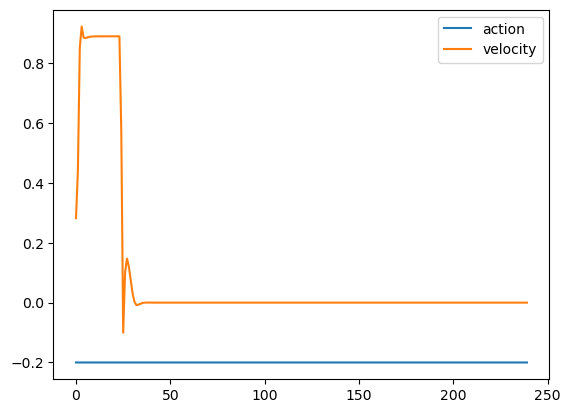

In [ ]:
rews = plot_rews(states)

## Debugging the Large Gradient Variance

#### Policy gradient sizes across enviroments

Text(0, 0.5, 'Log10 Policy gradient size')

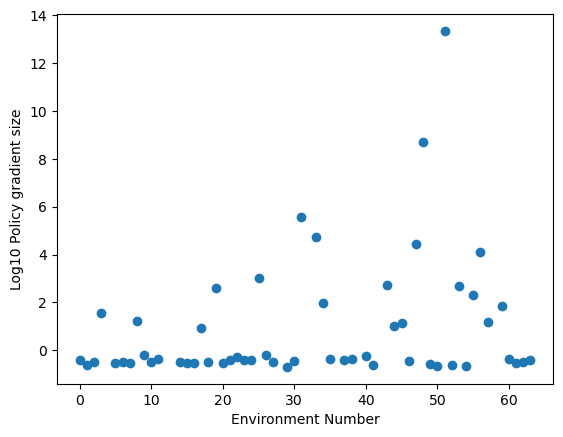

In [ ]:
import matplotlib.pyplot as plt
import jax.numpy as jp
import pickle
import jax
import operator

it = 1 # Step 1 has gradients size 1e15.
# Load policy gradients
bgrad_path = f"/home/andrew/Documents/thesis/jax_shac/shac/policy_gradients/bgrad_{it}.pkl"
bgrad = pickle.load(open(bgrad_path, "rb"))

# Calculate the norm over the env axis for all leaves.
def norm(l, axes):
    ret = jp.square(l)
    ret = jp.mean(ret, axis=axes)
    ret = jp.sqrt(ret)
    return ret

reduced_leaves = jax.tree_util.tree_map(lambda l: norm(
    l, axes=(range(1, len(l.shape)))), bgrad)
pg_size_per_env = jax.tree.reduce(operator.add, reduced_leaves)

num_envs = 64
x_axis = jp.linspace(0, num_envs-1, num_envs)
plt.scatter(x_axis, jp.log10(pg_size_per_env))
plt.xlabel("Environment Number")
plt.ylabel("Log10 Policy gradient size")

In [ ]:
# Repeat the offending unroll
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 0
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']


In [ ]:
state.info['reward_tuple']['action'].size == 64

True

In [ ]:
state.info['reward_tuple']['action']

Array([-0.8728971 , -0.9865786 , -0.9697148 , -0.9089221 , -1.0456685 ,
       -0.94092727, -0.9451862 , -1.1473181 , -1.0777584 , -1.1603782 ,
       -1.0881442 , -1.0230982 , -1.1129246 , -0.9549213 , -0.8028559 ,
       -1.0612354 , -0.843979  , -1.1217117 , -0.9394786 , -0.961573  ,
       -1.0062937 , -0.95115006, -0.8642511 , -1.1226293 , -1.1221776 ,
       -0.9587728 , -1.0226487 , -1.1012515 , -0.6825287 , -0.9520384 ,
       -0.87124586, -0.885466  , -1.0066658 , -1.1072596 , -1.0183716 ,
       -1.007945  , -1.1205506 , -0.94890773, -1.0407709 , -1.002066  ,
       -1.048817  , -0.9679921 , -0.9131506 , -1.0636973 , -0.9318269 ,
       -0.7719713 , -1.0328834 , -0.8952205 , -0.8981623 , -0.95087177,
       -1.0897388 , -1.1231223 , -1.0963877 , -0.84907913, -1.0642651 ,
       -0.8591824 , -0.94829386, -0.9671062 , -1.119221  , -1.2173092 ,
       -1.0934457 , -1.0448011 , -0.92605275, -0.9543048 ], dtype=float32)

In [ ]:
keys = state.info['reward_tuple'].keys()

def f(c, x):
    return c, x

jax.lax.scan(f, (None,), keys)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### Are large policy gradients caused by large mjx jacobians?

The answer: Sort of; small mjx jacobians don't result in large policy grads.

In [ ]:
# Repeat the offending unroll
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']


In [ ]:

long_jacs, states, state_h, extras = trainer.jac_rollout(ts.policy_params, 
                                                 ts.normalizer_params,
                                                 state, key, 3)

actions = extras["action"]

print(long_jacs.shape)

(64, 3, 37, 49)


9 nan policy gradients and 0 nan state gradients


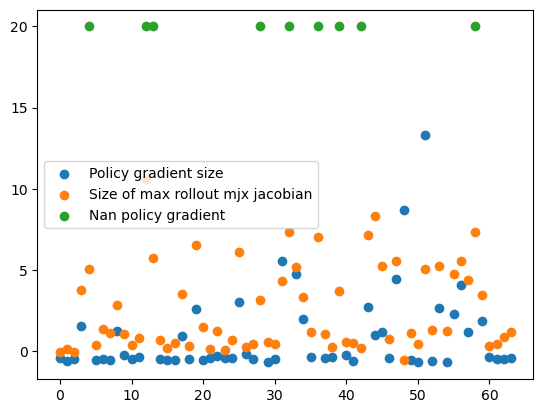

In [ ]:
jac_norms = norm(long_jacs, axes=(2, 3))
max_norm_per_env = jp.max(jac_norms, axis=1)

# Normalize both. 
# assert len(pg_size_per_env.shape) == 1
# assert len(max_norm_per_env.shape) == 1

# n_pg_size_per_env = pg_size_per_env / jp.linalg.norm(pg_size_per_env)
# n_max_norm_per_env = max_norm_per_env / jp.linalg.norm(max_norm_per_env)

# plt.plot(n_pg_size_per_env, label="Policy gradient size")
print("{} nan policy gradients and {} nan state gradients".format(
    jp.sum(jp.isnan(pg_size_per_env)),
    jp.sum(jp.isnan(max_norm_per_env))
))

# Also plot the nans
nan_inds = jp.argwhere(jp.isnan(pg_size_per_env))
nan_y = jp.ones(len(nan_inds)) * 20 # Just for visualization
plt.scatter(x_axis, jp.log10(pg_size_per_env) , label="Policy gradient size")
plt.scatter(x_axis, jp.log10(max_norm_per_env), label="Size of max rollout mjx jacobian")
plt.scatter(nan_inds, nan_y, label="Nan policy gradient")

plt.legend()

Text(0.5, 1.0, 'Max step jacobians vs policy gradients per env')

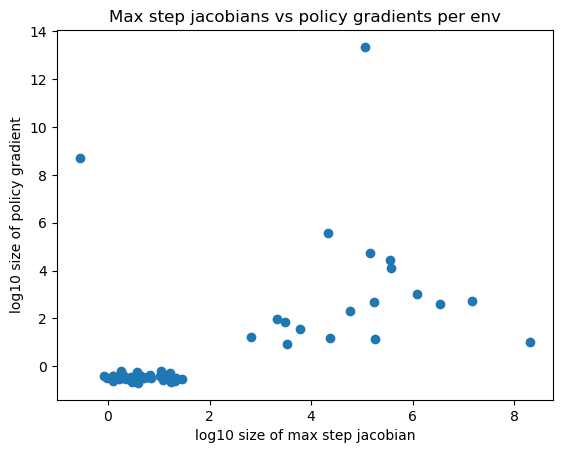

In [ ]:
plt.scatter(jp.log10(max_norm_per_env), jp.log10(pg_size_per_env))
plt.xlabel("log10 size of max step jacobian")
plt.ylabel("log10 size of policy gradient")
plt.title("Max step jacobians vs policy gradients per env")

#### Do large jacobians occur uniformly randomly?

In [ ]:
# Collect a rollout with a longer unroll length.
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, ts.normalizer_params,
                           state, key, 32)

actions = extras["action"]
print(long_jacs.shape)

(64, 32, 37, 49)


In [ ]:
jac_norms = norm(long_jacs, axes=(2, 3))
thresh = 100 # Based on above figure
big_jacs = jac_norms > thresh

plt.imshow(big_jacs)
plt.xlabel("Step")
plt.ylabel("Environment Index")

NameError: name 'norm' is not defined

#### State Space: what states result in large jacobians?

In [ ]:
# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']


In [ ]:

# long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, 
#                                                  ts.normalizer_params,
#                                                  state, key, 32)

# actions = extras["action"]
# print(long_jacs.shape)

In [ ]:

# import pickle
# pickle.dump(
#     (long_jacs, nstates),
#     open("/tmp/debugstates.pkl", "wb")
# )

In [ ]:
import pickle
long_jacs, nstates = pickle.load(open("/tmp/debugstates.pkl", "rb"))

In [ ]:
import mediapy as media
# Unbatch for env 1.
i_env = 1
def unvmap(tree, index):
    return jax.tree_util.tree_map(lambda x: x[index], tree)

rjacs = long_jacs[i_env]
rstate = unvmap(state, i_env)
rnstates = unvmap(nstates, i_env)

ims = trainer.render_states(rstate, rnstates, rjacs, 100)
media.show_video(ims, fps=1/trainer.env.dt)

Text(0, 0.5, 'Environment Index')

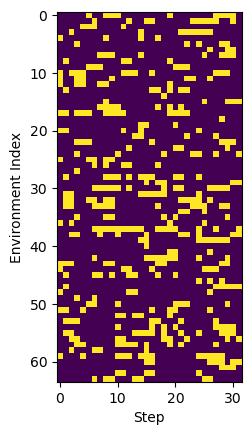

In [ ]:
jac_norms = norm(long_jacs, axes=(2, 3))
thresh = 100 # Based on above figure
big_jacs = jac_norms > thresh
import matplotlib.pyplot as plt
plt.imshow(big_jacs)
plt.xlabel("Step")
plt.ylabel("Environment Index")

#### Gradients during Resets

Conclusion: 
- Confirmed that the jacobian norm is zero upon resetting. If s_k+1 is done, the state gets reset on the same timestep. Then, ds_k+1/ds_k = 0. 

In [ ]:
import matplotlib.pyplot as plt
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, 
                                                 ts.normalizer_params,
                                                 state, key, 32)

actions = extras["action"]

Text(0, 0.5, 'Jacobian norm')

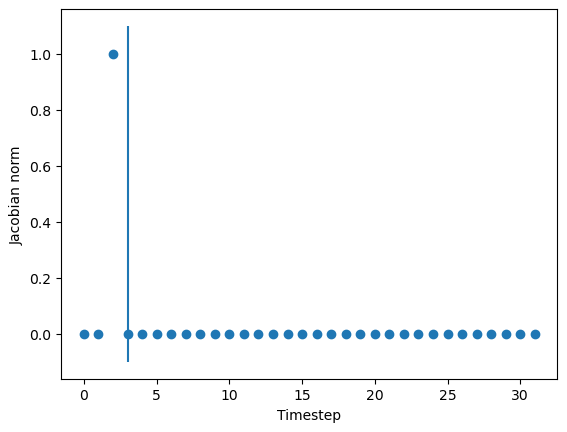

In [ ]:
# Unbatch for env 1.
i_env = 13
def unvmap(tree, index):
    return jax.tree_util.tree_map(lambda x: x[index], tree)

rjacs = long_jacs[i_env]
rstate = unvmap(state, i_env)
rnstates = unvmap(nstates, i_env)

dones = jp.concatenate([jp.reshape(rstate.done, newshape=(1,)),
                        rnstates.done])[:-1] # d0 to d_{H-1}
dones = jp.argwhere(dones)

num_dones = len(dones)
plt.vlines(dones, -0.1 * jp.ones(num_dones), 1.1 * jp.ones(num_dones))

# where are the jacs 0?
rjacs = norm(rjacs, axes=(1, 2))
zjacs = rjacs == 0
x_axis = jp.linspace(0, len(zjacs)-1, len(zjacs))
plt.scatter(x_axis, zjacs)
plt.xlabel("Timestep")
plt.ylabel("Jacobian norm")


#### Which partial derivatives blow up?

In [ ]:
import matplotlib.pyplot as plt
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, nstates, extras = trainer.jac_rollout(ts.policy_params, 
                                                 ts.normalizer_params,
                                                 state, key, 32)

actions = extras["action"]

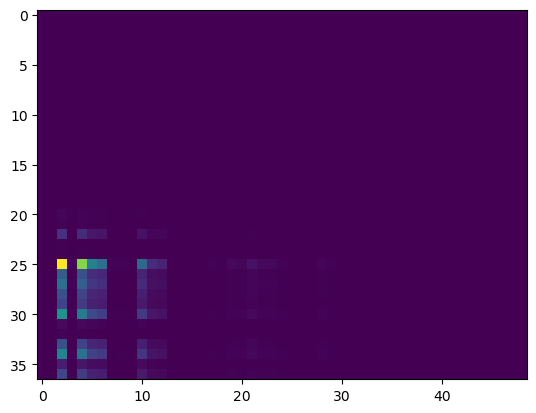

In [ ]:
# Jacobian Space
a_jacs = jp.abs(long_jacs)
c_jacs = jp.nanmean(a_jacs, axis=(0, 1))
plt.imshow(c_jacs)

In [ ]:
jp.sum(jp.isnan(long_jacs))

Array(555, dtype=int32)

(array([  47.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2000.]),
 array([-5.89237002e+10, -5.30313298e+10, -4.71389594e+10, -4.12465889e+10,
        -3.53542144e+10, -2.94618460e+10, -2.35694735e+10, -1.76771031e+10,
        -1.17847316e+10, -5.89236122e+09,  9.91237598e+03]),
 <BarContainer object of 10 artists>)

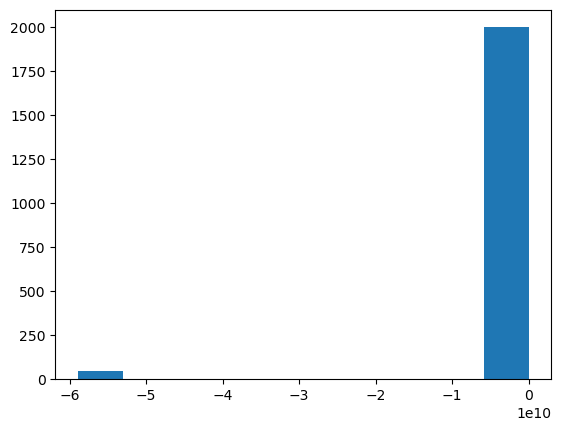

In [ ]:
qdim = trainer.env.sys.nq
dqdim = trainer.env.sys.nv
adim = trainer.env.sys.nu

# Aggregate
dqdq = long_jacs[...,:qdim,: qdim]
adqdq = jp.mean(dqdq, axis=(2, 3))

filler = jp.nanmean(adqdq)

# Not working.
adqdq = adqdq.at[jp.abs(adqdq) > 1e4].set(filler)

# Flatten
adqdq = jp.ravel(adqdq)
plt.hist(adqdq)

#### Do contacts cause large mjx jacobians?

In [ ]:
import matplotlib.pyplot as plt
from jax_shac.utils.trainer_utils import norm

# Collect a long rollout
it = 1 
algo_state = trainer.load_checkpoint(it)
ts = algo_state['training_state']
state = algo_state['env_state']
key = algo_state['unroll_keys']

long_jacs, states, state_h, extras = trainer.jac_rollout(ts.policy_params, 
                                                 ts.normalizer_params,
                                                 state, key, 32)

actions = extras["action"]

In [ ]:
# Large jacs mask; num_envs x unroll_length
ljac_mask = norm(long_jacs, axes=(2, 3)) > 100


# Any of four feet in contact.
in_contact_mask = (states.pipeline_state.contact.dist < 0).sum(axis=2)

# jac i in dim 1: deriv of si+1 wrt i.
# Say i+1 in contact. Then jac i should be large.
rljac_mask = jp.roll(ljac_mask, 1, axis=1) # 5% error
# rljac_mask = ljac_mask # 20% error

in_contact_and_large_jac = jp.logical_and(
    rljac_mask[:,1:,...],
    in_contact_mask[:,1:,...])

not_in_contact_and_large_jac = jp.logical_xor(
    in_contact_and_large_jac,
    rljac_mask[:,1:,...]
)
print(jp.sum(not_in_contact_and_large_jac) / jp.sum(ljac_mask))

0.057603687


In [ ]:
# Bug: actually this also registers breaking contact. 
make_contact_mask = jp.logical_xor(
    in_contact_mask[:, :-1, ...],
    jp.roll(in_contact_mask, -1, axis=1)[:, :-1, ...]
)

make_contact_and_large_jac = jp.logical_and(
    ljac_mask[:, :-1, ...],
    make_contact_mask)

not_make_contact_and_large_jac = jp.logical_xor(
    make_contact_and_large_jac,
    ljac_mask[:,:-1,...]
)

print(jp.sum(not_make_contact_and_large_jac) / jp.sum(ljac_mask))

0.73963135


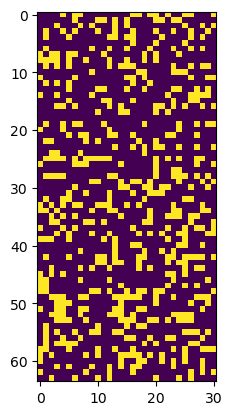

In [ ]:
plt.imshow(make_contact_mask)

Text(0.5, 1.0, 'Number of feet in ground contact')

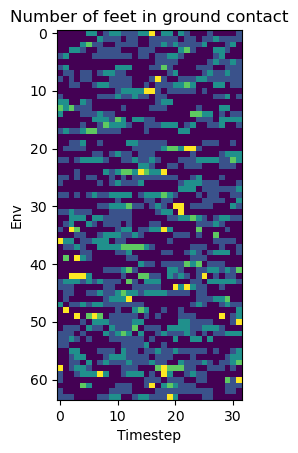

In [ ]:
plt.imshow(in_contact_mask)
plt.xlabel("Timestep")
plt.ylabel("Env")
plt.title("Number of feet in ground contact")

Text(0.5, 1.0, 'Large step jacobian')

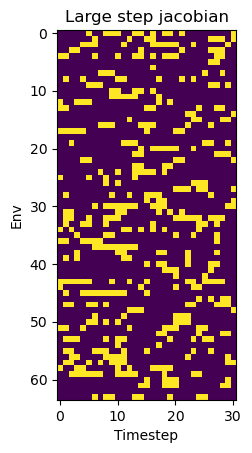

In [ ]:
plt.imshow(ljac_mask[:, :-1, ...])
plt.xlabel("Timestep")
plt.ylabel("Env")
plt.title("Large step jacobian")

In [ ]:
import mediapy as media
# Unbatch for env 1.
i_env = 63
def unvmap(tree, index):
    return jax.tree_util.tree_map(lambda x: x[index], tree)

rjacs = long_jacs[i_env]
rstates = unvmap(states, i_env)

ims = trainer.render_states(rstates, rjacs, 100)
media.show_video(ims, fps=1/trainer.env.dt)

In [ ]:
""" 
- Clipping individual partials
"""
# to_nan_mask = pg_size_per_env > 1e2

ex_leaf = bgrad['params']['hidden_0']['kernel']

cex_leaf = jp.clip(ex_leaf, -1, 1)

jp.sum(cex_leaf == -1) + jp.sum(cex_leaf == 1)

# reduced_leaves = jax.tree_util.tree_map(lambda l: norm(
#     l, axes=(range(1, len(l.shape)))), bgrad)
# pg_size_per_env = jax.tree.reduce(operator.add, reduced_leaves)

clipped_bgrads = jax.tree_util.tree_map(lambda l: jp.clip(l, -1, 1), bgrad)



In [ ]:
ex_leaf.size

802816

In [ ]:
nbgrad = jax.tree_util.tree_map(
    lambda x: jp.where(pg_size_per_env>1e2, x, jp.nan),
    bgrad
)


ValueError: Incompatible shapes for broadcasting: shapes=[(64,), (64, 256), ()]